# Mask R-CNN - Train on Shapes Dataset


This trains Mask R-CNN on our pig dataset. You'll need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.


In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import glob
import skimage.io

# Root directory of the project,
# needed for external modules etc
ROOT_DIR = os.path.abspath("../../") 

#todo: make paths relative 
DATA_DIR = "/home/blaise/code/grisehale_nmbu/data" #contains /train (and /val /test in the future)
TRAIN_DATA_DIR = DATA_DIR+"/train"
VAL_DATA_DIR = DATA_DIR+"/validation"

#sys.path.append(DATA_DIR)
ANNOTATION_FILE = "batch1_coco_2019-09-30_1132.json"
annotations_file_path = os.path.join(DATA_DIR,ANNOTATION_FILE)
#PIGS_ONLY_FOLDER = "/data/open_datasets/open_images_v5/images/pigsonly" #pigs from open image v5

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the mrcnn library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

#sys.path.append("/home/blaise/code/grisehale_nmbu/src/lbbx2coco")
sys.path.append(os.path.join(ROOT_DIR,"digipig/lbbx2coco"))
import olatools
import json
from PIL import Image, ImageDraw

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    print("downloading")
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/blaise/anaconda3/envs/nmbu37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/blaise/anaconda3/envs/nmbu37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/blaise/anaconda3/envs/nmbu37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/blaise/anaconda3/envs/nmbu37/lib/python3

## Configurations

In [2]:
class ShapesConfig(Config):
    """
    Edit: adopting example to train on pig images
    
    Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "pigs"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    # seems to ba an issue with more than 1 gpu see issue no 921 in repo
    # fix : https://github.com/yoninachmany/spacenet-rio-buildings-mask-rcnn/commit/5a2a68e830b6878a9a06175ac9be4c3bfa22f1bc
    GPU_COUNT = 3
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    # start with pigs only
    NUM_CLASSES = 1 + 3  # background + 3 pig_classes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 1280

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels // added 256, 512 -> got: IndexError: index 5 is out of bounds for axis 0 with size 5

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 128 #org sugg val 32

    # Use a small epoch since the data is simple
    #STEPS_PER_EPOCH = 100
    #"If you have a training set of fixed size you can ignore it.." [1]

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    #similar to steps_per_epoch but on the validation data set instead on the training data. If you have the time to go through your whole validation data set I recommend to skip this parameter. [1]
    
    #ref [1] https://datascience.stackexchange.com/questions/29719/how-to-set-batch-size-steps-per-epoch-and-validation-steps

config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     3
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      3
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1280
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1280 1280    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset



Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class PigsDataset(utils.Dataset):

    def __init__(self, annotations, images_dir, class_map=None):
        super().__init__(class_map=class_map)
        self.annotations_file = annotations
        self.image_folder = images_dir
        
    def load_pigs(self, count, height, width, datadir):
        """
        load pig files into dataset object from mrcnn
        """
        
        # Add classes
        self.add_class("pigs", 1, "pig_body")
        self.add_class("pigs", 2, "pig_head")
        self.add_class("pigs", 3, "pig_tail")

        # Add images to image list (see parent class)
        
        counter = 0
        for file in os.listdir(datadir):
            # Todo: check for ".png" extention to exclude irrelevant files e.g. os-generated files
            if counter>=count:
                break
            else: counter = counter + 1
            tmp_id = int(olatools.intify_filename(file))
            test = self.add_image("pigs", image_id=tmp_id, path=file) #width=width, height=height, bg_color=bg_color, shapes="pig")            
            #test is an un-used return value for debuging
        
        
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        datadir =  self.image_folder #"/home/blaise/code/grisehale_nmbu/data/train" #omg!!!!
        # Load image
        image = skimage.io.imread(datadir+"/"+self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image
        
#    def image_reference(self, image_id):
#        """Return the shapes data of the image."""

    
    def load_mask(self, image_id):
        """instance masks for shapes of the given image ID.
        """
        
        with open(annotations_file_path, 'r') as rf:
            annotations_file_object = json.load(rf)
            
        use_static_dimentions = True
        width = 1280
        height = 720
        count = 0
        mask = np.zeros([height, width, count], dtype=np.uint8)
        class_ids = np.zeros(0)
        
        #check if id is in map
        map_keys = self.image_from_source_map.keys()
        if (image_id in self.image_from_source_map.values()):
            for annotation in annotations_file_object["annotations"]:
                # todo: add check to see if id exists in train folder images
                id_x = annotation["image_id"]
                #image_id is sequential number of images 0/1 - 582/583
                #annotations_file_object contains id on form 54171016201710171313390240015840
                #the map function uses this form to map between the two: pigs.54171016201710171313390240015840 maps 0-500
                
                if 'pigs.'+str(annotation["image_id"]) in self.image_from_source_map:
                    if (image_id == self.image_from_source_map['pigs.'+str(annotation["image_id"])]) :
                        
                        #find img dimentions (there must be a bettery way to do this) 
                        if not(use_static_dimentions):
                            for image in annotations_file_object["images"]:
                                if image["id"]==image_id:
                                    height = image["height"]
                                    width = image["width"]

                        class_ids= np.append(class_ids,annotation["category_id"])
                        polygon = annotation["segmentation"][0]
                        polypoints = [np.array(olatools.get_xy_pairs_vector_from_xyxy_list(polygon))]

                        img = np.zeros([height, width,  1], np.uint8)
                        img = cv2.fillPoly(img, polypoints,(255,255,255))
                        mask = np.append(mask,img,2)
        else:
            print("did not found id ")
            print(self.image_from_source_map)
        return mask.astype(np.bool), class_ids.astype(np.int32)
          

In [5]:
# Training dataset
dataset_train = PigsDataset(annotations_file_path, TRAIN_DATA_DIR)
dataset_train.load_pigs(531, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], TRAIN_DATA_DIR)
dataset_train.prepare()

# Validation dataset
dataset_val = PigsDataset(annotations_file_path, VAL_DATA_DIR)
dataset_val.load_pigs(52, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], VAL_DATA_DIR)
dataset_val.prepare()

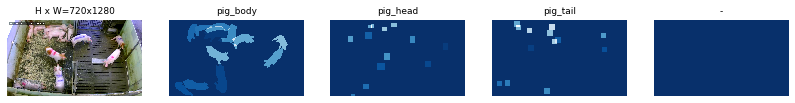

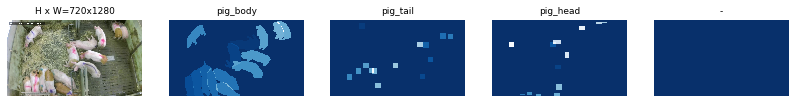

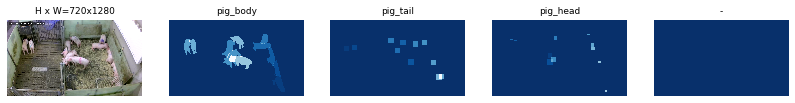

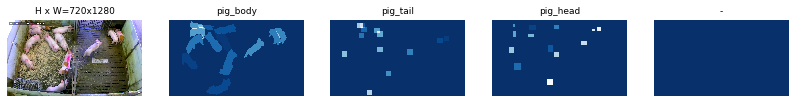

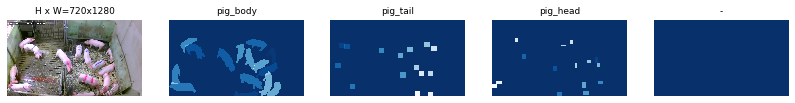

In [6]:
# Load and display random samples from validation
image_ids = np.random.choice(dataset_val.image_ids, 5)

for image_id in image_ids:
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names)

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

# delete below after training 2020-01-27

# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

#model_path = os.path.join(MODEL_DIR, "mask_rcnn_pig1-t500-bigimg-train_data_only_deleteme.h5")
#model.keras_model.save_weights(model_path)

/home/blaise/anaconda3/envs/nmbu37/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



Starting at epoch 0. LR=0.001

Checkpoint Path: /home/blaise/code/grisehale_nmbu/Mask_RCNN/logs/pigs20200224T1101/mask_rcnn_pigs_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistri

/home/blaise/anaconda3/envs/nmbu37/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/blaise/anaconda3/envs/nmbu37/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/blaise/anaconda3/envs/nmbu37/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/blaise/anaconda3/envs/nmbu37/lib/python3.7/site-packages/keras/engine/training_gen



Epoch 1/1
1000/1000 [==============================] - 1543s 2s/step - loss: 1.8933 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 0.6981 - mrcnn_class_loss: 0.3926 - mrcnn_bbox_loss: 0.3777 - mrcnn_mask_loss: 0.3790 - val_loss: 1.8214 - val_rpn_class_loss: 0.0252 - val_rpn_bbox_loss: 0.6654 - val_mrcnn_class_loss: 0.3619 - val_mrcnn_bbox_loss: 0.4042 - val_mrcnn_mask_loss: 0.3646

Starting at epoch 1. LR=0.0001

Checkpoint Path: /home/blaise/code/grisehale_nmbu/Mask_RCNN/logs/pigs20200224T1101/mask_rcnn_pigs_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b

/home/blaise/anaconda3/envs/nmbu37/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/blaise/anaconda3/envs/nmbu37/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/blaise/anaconda3/envs/nmbu37/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/blaise/anaconda3/envs/nmbu37/lib/python3.7/site-packages/keras/engine/training_gen

Epoch 2/2
1000/1000 [==============================] - 1646s 2s/step - loss: 1.4397 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 0.5067 - mrcnn_class_loss: 0.3052 - mrcnn_bbox_loss: 0.2715 - mrcnn_mask_loss: 0.3316 - val_loss: 1.4892 - val_rpn_class_loss: 0.0196 - val_rpn_bbox_loss: 0.5619 - val_mrcnn_class_loss: 0.2724 - val_mrcnn_bbox_loss: 0.2852 - val_mrcnn_mask_loss: 0.3502


In [10]:
model_path = os.path.join(MODEL_DIR, "mask_rcnn_pig1-t500-bigimg-train_data_deletethis.h5")
model.keras_model.save_weights(model_path)

In [ ]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

model_path = os.path.join(MODEL_DIR, "mask_rcnn_pig1-t500-bigimg-train_data_only.h5")
model.keras_model.save_weights(model_path)

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_pig1-t500-bigimg.h5")
model.keras_model.save_weights(model_path)

## Detection

In [11]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(MODEL_DIR, "mask_rcnn_pig1-t500-bigimg-train_data_deletethis.h5")
# model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /home/blaise/code/grisehale_nmbu/Mask_RCNN/logs/mask_rcnn_pig1-t500-bigimg-train_data_deletethis.h5


original_image           shape: (1280, 1280, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max: 1280.00000  int64
gt_class_id              shape: (42,)                 min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (42, 4)               min:   39.00000  max: 1157.00000  int32
gt_mask                  shape: (1280, 1280, 42)      min:    0.00000  max:    1.00000  bool


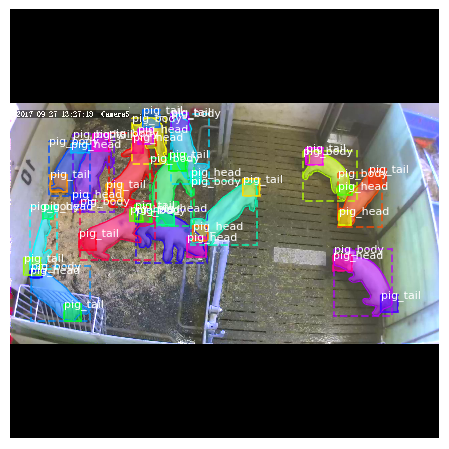

In [12]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Will fail with inputs not countaining expected classes

number_of_eval_images = 50
image_ids = np.random.choice(dataset_val.image_ids, number_of_eval_images)

APs = []
gt_match_df = pd.DataFrame( columns=["gt_class_id","gt_match"])

performance_summary_df = pd.DataFrame( columns=["img","num_gt_pigs","num_gt_heads","num_gt_tails",\
                                                "num_pred_pigs", "num_pred_heads", "num_pred_tails",\
                                               "num_match_pigs", "num_match_heads", "num_match_tails"])

for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    
    APs.append(AP)
    
    unique_pred, counts_pred = np.unique(r['class_ids'], return_counts=True)
    num_pred_pigs = counts_pred[0]
    num_pred_heads = counts_pred[1]
    num_pred_tails = counts_pred[2]
    
    unique_gt, counts_gt = np.unique(gt_class_id, return_counts=True)
    num_gt_pigs = counts_gt[0]
    num_gt_heads = counts_gt[1]
    num_gt_tails = counts_gt[2]
    
    gt_match, pred_match, overlaps = utils.compute_matches(
        gt_bbox, gt_class_id, gt_mask,
        r["rois"], r["class_ids"], r["scores"], r['masks'],
        0.5)
    
    tmp_data = pd.DataFrame({"gt_class_id":gt_class_id, "gt_match":gt_match})
    gt_match = tmp_data.query("gt_match > -1").groupby("gt_class_id").count()
    
    num_match_pigs = gt_match.query("gt_class_id == 1").values[0][0]
    num_match_heads = gt_match.query("gt_class_id == 2").values[0][0]
    num_match_tails = gt_match.query("gt_class_id == 3").values[0][0]
    
    
    
    tmp_summary = pd.DataFrame({
        "img":image_id,
        "num_gt_pigs": num_gt_pigs,
        "num_gt_heads": num_gt_heads,
        "num_gt_tails": num_gt_tails,
        "num_pred_pigs": num_pred_pigs, 
        "num_pred_heads": num_pred_heads, 
        "num_pred_tails": num_pred_tails,
        "num_match_pigs": num_match_pigs, 
        "num_match_heads": num_match_heads, 
        "num_match_tails": num_match_tails,},index=[image_id])
    
    performance_summary_df = performance_summary_df.append(tmp_summary) #ignore_index = True)
    gt_match_df = gt_match_df.append(tmp_data, ignore_index = True)
    
    if num_gt_pigs<num_match_pigs or num_gt_heads<num_match_heads or num_gt_tails<num_match_tails:
        print('inconsistent number of matches: more matches than ground truths')


In [ ]:
performance_summary_df

In [ ]:
performance_summary_df.to_csv("performance_summary_evaluation.csv")

In [ ]:
gt_pigs = performance_summary_df['num_gt_pigs'].sum()
gt_heads = performance_summary_df['num_gt_heads'].sum()
gt_tails = performance_summary_df['num_gt_tails'].sum()

pred_pigs = performance_summary_df['num_pred_pigs'].sum()
pred_heads = performance_summary_df['num_pred_heads'].sum()
pred_tails = performance_summary_df['num_pred_tails'].sum()

tp_pigs = performance_summary_df['num_match_pigs'].sum()
tp_heads = performance_summary_df['num_match_heads'].sum()
tp_tails = performance_summary_df['num_match_tails'].sum()

fp_pigs = pred_pigs - tp_pigs
fp_heads = pred_heads - tp_heads
fp_tails = pred_tails - tp_tails

fn_pigs = gt_pigs - tp_pigs
fn_heads = gt_heads - tp_heads
fn_tails = gt_tails - tp_tails


#precision = tp / (tp+fp)
pigs_precision = tp_pigs / (tp_pigs + fp_pigs)
heads_precision = tp_heads / (tp_heads + fp_heads)
tails_precision = tp_tails / (tp_tails + fp_tails)

#recall = tp / (fn+tp)
pigs_recall = tp_pigs / (fn_pigs + tp_pigs)
heads_recall = tp_heads / (fn_heads + tp_heads)
tails_recall = tp_tails / (fn_tails + tp_tails)

In [ ]:
print(f"    pigs precision: {pigs_precision} \n    pigs recall: {pigs_recall} \n")
print(f"    heads precision: {heads_precision} \n    heads recall: {heads_recall} \n")
print(f"    tails precision: {tails_precision} \n    tails recall: {tails_recall} \n")

In [ ]:
print(f"pigs: \ntp: {tp_pigs}, \nfp: {fp_pigs}, \nfn: {fn_pigs} \n")
print(f"heads: \ntp: {tp_heads}, \nfp: {fp_heads}, \nfn: {fn_heads} \n")
print(f"tails: \ntp: {tp_tails}, \nfp: {fp_tails}, \nfn: {fn_tails} \n")